# **Projet Biostatistique - Les genes relatifs au cancer du poumon**


**Objectif :**
Dans ce projet j'analyserai les donnees d'expression genique du type de cancer du poumon appele Carcinome a Cellules Squameuses afin de trouver le coefficient de correlation pour le gene lorsque le tissu est sain et lorsqu'il est cancereux.
Pour cela, je stockerai les differents resultats dans des tableaux excels (disponibles apres compilation) et un graphique en fin de projet.

**Data :** Les donnees ont ete extraites a partir de deux fichiers texte, l'un pour les tissus cancereux et l'autre pour les tissus sains. Les fichiers *lusc-rsem-fpkm-tcga-t_paired.txt* et *lusc-rsem-fpkm-tcga_paired.txt* sont trouvables [en cliquant ce lien](https://github.com/mskcc/RNAseqDB/tree/master/data/normalized)

# **Traitement des donnees**

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi
import pandas as pd

# Definition de fonctions pour extraire les noms de genes et les donnees a partir de fichiers txt


def extract_names(filename: str):
    nameset = []
    with open(filename) as f:
        for index, line in enumerate(f):
            line = line.split("\t")
            if index == 0:
                continue
            nameset.append(np.array(line[0:2]))
    return nameset



In [ ]:
# Extraction des donnees saines, cancereuses et des noms de genes


def extract_data(filename: str):
    dataset = []
    with open(filename) as f:
        for index, line in enumerate(f):
            line = line.split("\t")
            if index == 0:
                continue
            dataset.append(np.array(line[2:]).astype(np.float))
    return dataset


healthy_data = extract_data("lusc-rsem-fpkm-tcga_paired.txt")
cancerous_data = extract_data("lusc-rsem-fpkm-tcga-t_paired.txt")
data_names = extract_names("lusc-rsem-fpkm-tcga_paired.txt")

<ipython-input-14-7bd775e2705e>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dataset.append(np.array(line[2:]).astype(np.float))


In [ ]:
# Suppression des donnees ayant une expression nulle dans plus de 50% des echantillons
iterator = 0
for row in healthy_data:
    sum = 0
    for column in row:
        if column == 0:
            sum += 1
    if sum > 25:
        healthy_data.pop(iterator)
        data_names.pop(iterator)
        cancerous_data.pop(iterator)
    iterator += 1

iterator = 0
for row in cancerous_data:
    sum = 0
    for column in row:
        if column == 0:
            sum += 1
    if sum > 25:
        healthy_data.pop(iterator)
        data_names.pop(iterator)
        cancerous_data.pop(iterator)
    iterator += 1

In [ ]:
# Calcul des coefficients de correlation de Pearson...
pearson_correlation = []
rel_p_values = []
ind_p_values = []

for i in range(0, len(healthy_data)):
    pearson_cc = stats.pearsonr(cancerous_data[i], healthy_data[i])[0]
    pearson_correlation.append(pearson_cc)

#...et des valeurs p
    rel_p_value = stats.ttest_rel(cancerous_data[i], healthy_data[i]).pvalue
    ind_p_value = stats.ttest_ind(cancerous_data[i], healthy_data[i]).pvalue
    rel_p_values.append(rel_p_value)
    ind_p_values.append(ind_p_value)


pearson_correlation_numpy = np.array(pearson_correlation)

In [41]:
# Enregistrement des resultats dans un fichier Excel : Correlations
df_names = pd.DataFrame(data_names, columns=["Nom gene", "Gene ID"])
df_names["Pearson CC"] = pearson_correlation_numpy
filepath = "Correlations.xlsx"
df_names.to_excel(filepath)

In [ ]:
# Tri des coefficients de correlation
sorted_coeff = sorted(pearson_correlation_numpy)

In [ ]:
# Identification des genes avec les coefficients de correlation les plus eleves et les plus bas
max_index = np.argmax(pearson_correlation_numpy)
min_index = np.argmin(pearson_correlation_numpy)

# Correction des valeurs p (FDR correction)
rel_fdr = multi.multipletests(rel_p_values, method="fdr_bh")
ind_fdr = multi.multipletests(ind_p_values, method="fdr_bh")

common_rel_genes = []
common_ind_genes = []
distinct_rel_genes = []
distinct_ind_genes = []

La correction FDR est appliquee pour contrôler le taux de faux positifs. On veut donc les resultats corriges pour tenir compte des comparaisons multiples et reduire les risques d'obtenir des resultats significatifs par pur hasard.

In [ ]:
# Classification des genes en communs et distincts qui satisfont l'hypothese pour les tests dependants et independants
for i in range(0, len(ind_fdr[0])):

    if not ind_fdr[0][i] and ind_p_values[i] < 0.05:
        distinct_ind_genes.append((data_names[i], ind_fdr[1][i], ind_p_values[i]))
    elif ind_fdr[0][i]:
        common_ind_genes.append((data_names[i], ind_fdr[1][i], ind_p_values[i]))


for i in range(0, len(rel_fdr[0])):

    if not rel_fdr[0][i] and rel_p_values[i] < 0.05:
        distinct_rel_genes.append((data_names[i], rel_fdr[1][i], rel_p_values[i]))
    elif rel_fdr[0][i]:
        common_rel_genes.append((data_names[i], rel_fdr[1][i], rel_p_values[i]))

In [39]:
# Enregistrement des resultats dans des fichiers Excel distincts

# Genes communs dependants
df_com_rel = pd.DataFrame(
    common_rel_genes, columns=["Nom gene", "Apres FDR", "Avant FDR"]
)
filepath = "commun_dep_genes.xlsx"
df_com_rel.to_excel(filepath, index=False)

# Genes communs independants
df_com_ind = pd.DataFrame(
    common_ind_genes, columns=["Nom gene", "Apres FDR", "Avant FDR"]
)
filepath = "commun_ind_genes.xlsx"
df_com_ind.to_excel(filepath, index=False)

# Genes distincts dependants
df_dis_rel = pd.DataFrame(
    distinct_rel_genes, columns=["Nom gene", "Apres FDR", "Avant FDR"]
)
filepath = "distinct_dep_genes.xlsx"
df_dis_rel.to_excel(filepath, index=False)

# Genes distincts independants
df_dis_ind = pd.DataFrame(
    distinct_ind_genes, columns=["Nom gene", "Apres FDR", "Avant FDR"]
)
filepath = "distinct_ind_genes.xlsx"
df_dis_ind.to_excel(filepath, index=False)


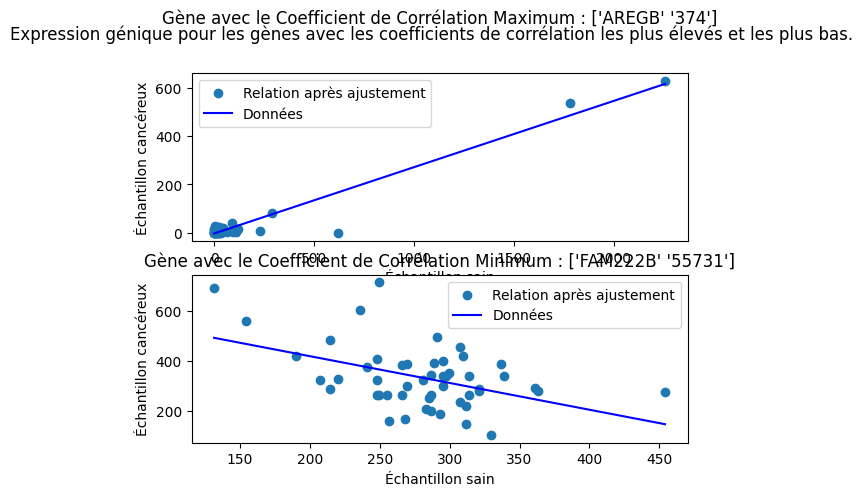

In [75]:
# Creation du graphique
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle(
    "Expression genique pour les genes avec les coefficients de correlation les plus eleves et les plus bas."
    )
ax1.set_title(f"Gene avec le Coefficient de Correlation Maximum : {data_names[max_index]}\n\n")
ax2.set_title(f"Gene avec le Coefficient de Correlation Minimum : {data_names[min_index]}")
ax1.scatter(healthy_data[max_index], cancerous_data[max_index])
ax1.set(xlabel="echantillon sain", ylabel="echantillon cancereux")
ax1.plot(
    np.unique(healthy_data[max_index]),
    np.poly1d(np.polyfit(healthy_data[max_index], cancerous_data[max_index], 1))(
        np.unique(healthy_data[max_index])
    ),
    color="blue",
)


ax2.scatter(healthy_data[min_index], cancerous_data[min_index])
ax2.set(xlabel="echantillon sain", ylabel="echantillon cancereux")
ax2.plot(
    np.unique(healthy_data[min_index]),
    np.poly1d(np.polyfit(healthy_data[min_index], cancerous_data[min_index], 1))(
        np.unique(healthy_data[min_index])
    ),
    color="blue",
)
ax1.legend(["Relation apres ajustement", "Donnees"])
ax2.legend(["Relation apres ajustement", "Donnees"])

# Affichage du graphique
plt.show()


# **Explication des differentes etapes du code**
J'ai principalement utilise Python pour mener a bien notre calcul et notre analyse. La sequence de nos tests etait la suivante :

1. J'ai nettoye les donnees en eliminant tout gene dont l'expression etait egale a 0 dans plus de 50%.

2. En utilisant la fonction scipy.stats.pearsonr de Python, j'ai calcule le coefficient de correlation de Pearson entre le même gene dans les tissus sains et cancereux. J'ai extrait a la fois les genes avec les coefficients de correlation positifs les plus eleves et les coefficients de correlation negatifs les plus bas en utilisant les fonctions min et max de Python.

3. J'ai exporte chaque gene avec son coefficient de correlation vers une feuille de calcul Excel en utilisant la bibliotheque Pandas de Python.

4. J'ai trace une relation entre les expressions geniques dans les tissus sains et cancereux des genes mentionnes ci-dessus en utilisant matplotlib.pyplot de Python.

5. La procedure de test d'hypothese a ete realisee en utilisant scipy.stats.ttest.rel pour tester si les echantillons etaient apparies et scipy.stats.ttest.ind si les echantillons etaient independants.

6. J'ai ensuite applique la methode de correction FDR sur les valeurs p resultantes des deux tests precedents.

7. J'ai compare les valeurs p des deux cas avant et apres l'application du test FDR, identifiant ainsi les genes dont les valeurs n'ont pas ete affectees par la correction FDR que nous avons appeles genes communs. D'autre part, les genes dont les valeurs ont ete affectees par la correction FDR ont ete appeles genes distincts.

8. J'ai exporte tous les genes communs independants, les genes communs relatifs, les genes distincts independants et les genes distincts relatifs vers 4 feuilles de calcul differentes.



# **Conclusion**

Apres l'execution du code, nous avons constate que le gene qui presentait le coefficient de correlation positif le plus eleve etait **AREGB** avec un CC de **0.969044144297071**. En revanche, le gene ayant le CC negatif le plus eleve etait **FAM222B** avec un CC de **-0.452807278524708**. Le graphique ci dessus montre la relation entre les expressions geniques dans les tissus cancereux et sains pour ces deux genes.